# Climate modes and diagnostics

In [1]:
from dask.distributed import Client,LocalCluster
from dask_jobqueue import PBSCluster

In [2]:
# One node on Gadi has 48 cores - try and use up a full node before going to multiple nodes (jobs)

walltime = '01:00:00'
cores = 10
memory = str(4 * cores) + 'GB'

cluster = PBSCluster(walltime=str(walltime), cores=cores, memory=str(memory), processes=cores,
                     job_extra_directives=['-q normal',
                                           '-P w42',
                                           '-l ncpus='+str(cores),
                                           '-l mem='+str(memory),
                                           '-l storage=gdata/w42+gdata/rt52'],
                     local_directory='$TMPDIR',
                     job_directives_skip=["select"])

In [3]:
cluster.scale(jobs=1)
client = Client(cluster)

In [4]:
client

Connection method: Cluster object,Cluster type: dask_jobqueue.PBSCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://10.6.122.11:35835,Workers: 0
Dashboard: /proxy/8787/status,Total threads: 0
Started: Just now,Total memory: 0 B


In [5]:
%load_ext autoreload
%autoreload 2

In [6]:
# import warnings

import xarray as xr
import numpy as np

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
# from mpl_toolkits.axes_grid1.inset_locator import inset_axes

import cartopy.crs as ccrs
import cartopy
cartopy.config['pre_existing_data_dir'] = '/g/data/w42/dr6273/work/data/cartopy-data/'
cartopy.config['data_dir'] = '/g/data/w42/dr6273/work/data/cartopy-data/'

import string
letters = list(string.ascii_lowercase)

In [7]:
%cd /g/data/w42/dr6273/work/AEMO_compound_events/

import functions as fn

/g/data/w42/dr6273/work/AEMO_compound_events


In [8]:
plt_params = fn.get_plot_params()
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

In [9]:
plt_params

{'lines.linewidth': 1.3,
 'hatch.linewidth': 0.5,
 'font.size': 7,
 'legend.fontsize': 6,
 'legend.columnspacing': 0.7,
 'legend.labelspacing': 0.03,
 'legend.handlelength': 1.0,
 'axes.linewidth': 0.5,
 'axes.titlesize': 8}

In [10]:
years = range(1959, 2022)

data_fp = '/g/data/w42/dr6273/work/data/'

season_dict = fn.get_seasons()

# Load masks

In [11]:
rez_mask = fn.get_rez_mask()

# Load energy source and demand data

Sources: daily wind, daily solar and monthly runoff

In [12]:
rez_100w = xr.open_zarr(
    '/g/data/w42/dr6273/work/projects/Aus_energy/data/100w_era5_daily_1400UTC_sfc_'+str(years[0])+'-'+str(years[-1])+'_REZ_region_mean.zarr',
    consolidated=True
)['100w']#.compute()

In [13]:
rez_mssrd = xr.open_zarr(
    '/g/data/w42/dr6273/work/projects/Aus_energy/data/mssrd_era5_daily_1400UTC_sfc_'+str(years[0])+'-'+str(years[-1])+'_REZ_region_mean.zarr',
    consolidated=True
)['mssrd']#.compute()

Aus - gridded

In [14]:
aus_100w = xr.open_zarr(
    '/g/data/w42/dr6273/work/data/era5/100w/100w_era5_daily_1400UTC_sfc_'+str(years[0])+'-'+str(years[-1])+'_AUS_region.zarr',
    consolidated=True
)['w100']

In [15]:
aus_mssrd = xr.open_zarr(
    '/g/data/w42/dr6273/work/data/era5/msdwswrf/msdwswrf_era5_daily_1400UTC_sfc_'+str(years[0])+'-'+str(years[-1])+'_AUS_region.zarr',
    consolidated=True
)['msdwswrf']

Thresholds for event definitions

In [16]:
thresh_100w = rez_100w.chunk({'time': -1}).quantile(0.25, ['time', 'region']) #4 # Close to all region-time 25th percentile of 4.19
thresh_mssrd = rez_mssrd.chunk({'time': -1}).quantile(0.25, ['time', 'region']) #170 # All region-time 25th percentile is 132.7

### Events

In [17]:
events_100w = fn.get_events(rez_100w, thresh_100w, tail='lower').compute()

In [18]:
events_mssrd = fn.get_events(rez_mssrd, thresh_mssrd, tail='lower').compute()

In [19]:
events_100w_mssrd = fn.get_compound_events(rez_100w, rez_mssrd, thresh_100w, thresh_mssrd).compute()

### Daily events over all regions

In [20]:
simul_100w = fn.concurrent_lulls(events_100w, [1, 3, 5, 7], rez_mask)
simul_mssrd = fn.concurrent_lulls(events_mssrd, [2, 3, 6, 7], rez_mask)
simul_100w_mssrd = fn.concurrent_lulls(events_100w_mssrd, [3, 7], rez_mask)

### Seasonal events over all regions

In [21]:
# season_100w = fn.seasonal_mean(simul_100w)
# season_mssrd = fn.seasonal_mean(simul_mssrd)
# season_100w_mssrd = fn.seasonal_mean(simul_100w_mssrd)

# Load diagnostics and climate mode indices

### Daily diagnostics

500 hPa geopotential height

In [22]:
daily_z500_anoms = xr.open_zarr(
    '/g/data/w42/dr6273/work/data/era5/z/z_anoms_era5_daily_1400UTC_pl_'+str(years[0])+'-'+str(years[-1])+'_extended_Aus_region.zarr',
    consolidated=True
)['z'].squeeze()

MSLP

In [23]:
daily_mslp = xr.open_zarr(
    '/g/data/w42/dr6273/work/data/era5/mslp/mslp_era5_daily_1400UTC_'+str(years[0])+'-'+str(years[-1])+'_extended_Aus_region.zarr',
    consolidated=True
)['mslp']

In [24]:
daily_mslp_anoms = xr.open_zarr(
    '/g/data/w42/dr6273/work/data/era5/mslp/mslp_anoms_era5_daily_1400UTC_'+str(years[0])+'-'+str(years[-1])+'_extended_Aus_region.zarr',
    consolidated=True
)['mslp']

100u and 100v

In [25]:
daily_u100 = xr.open_zarr(
    '/g/data/w42/dr6273/work/data/era5/100u/100u_era5_daily_1400UTC_sfc_'+str(years[0])+'-'+str(years[-1])+'_extended_AUS_region.zarr',
    consolidated=True
)['u100']

In [26]:
daily_v100 = xr.open_zarr(
    '/g/data/w42/dr6273/work/data/era5/100v/100v_era5_daily_1400UTC_sfc_'+str(years[0])+'-'+str(years[-1])+'_extended_AUS_region.zarr',
    consolidated=True
)['v100']

Tcc

In [27]:
daily_tcc = xr.open_zarr(
    '/g/data/w42/dr6273/work/data/era5/tcc/tcc_era5_12hr_2000-0800UTC_'+str(years[0])+'-'+str(years[-1])+'_extended_Aus_region.zarr',
    consolidated=True
)['tcc']

In [28]:
daily_tcc_anoms = xr.open_zarr(
    '/g/data/w42/dr6273/work/data/era5/tcc/tcc_anoms_era5_12hr_2000-0800UTC_'+str(years[0])+'-'+str(years[-1])+'_extended_Aus_region.zarr',
    consolidated=True
)['tcc']

In [29]:
# TCC has 0800UTC time. Re-assign to 1400UTC to match other variables
daily_tcc = daily_tcc.assign_coords({'time': daily_u100.time})

In [30]:
daily_tcc_anoms = daily_tcc_anoms.assign_coords({'time': daily_u100.time})

2m T

In [31]:
daily_2t = xr.open_zarr(
    '/g/data/w42/dr6273/work/data/era5/2t/2t_era5_daily_1400UTC_sfc_'+str(years[0])+'-'+str(years[-1])+'_extended_AUS_region.zarr',
    consolidated=True
)['t2m']

In [32]:
daily_2t_anoms = xr.open_zarr(
    '/g/data/w42/dr6273/work/data/era5/2t/2t_anoms_era5_daily_1400UTC_sfc_'+str(years[0])+'-'+str(years[-1])+'_extended_AUS_region.zarr',
    consolidated=True
)['t2m']

# Daily diagnostics on spatially extensive wind/solar/compound drought days

In [33]:
def get_plot_data(events_dict, diag1, diag2, diag1_name, diag2_name, thresh):
    """
    Compute the data needed for plotting and save to a dictionary.
    We do this so we can tweak the figure without needed to process
    the data each time.
    
    events_dict: dictionary with events for each energy type
    diag1, diag2: dataarrays of diagnostic variables
    diag1_name, diag2_name: str. names of diag vars for dict.
    thresh: threshold used to define 'spatially extensive' events.
    """
    plot_dict = {}
    for season in list(season_dict.keys())[1:]:
        
        plot_dict[season] = {}
        
        for name, var in zip(events_dict.keys(), events_dict.values()):
            plot_dict[season][name] = {}
            
            years, n_events, p_1 = fn.composite_data(
                var,
                diag1,
                season,
                thresh
            )

            _, _, p_2 = fn.composite_data(
                var,
                diag2,
                season,
                thresh
            )
            
            plot_dict[season][name][diag1_name] = p_1.compute()
            plot_dict[season][name][diag2_name] = p_2.compute()
            plot_dict[season][name]['n_events'] = n_events
            
    return plot_dict

In [34]:
def region_data(simul_da, event_da, region_codes, season, thresh):
    """
    Get data of each region's frequency of occurrence
    in spatially extensive event days.
    
    simul_da: simultaneous events i.e. total number of daily events
                across all regions
    event_da: events by region
    region_codes: regions of interest e.g. wind only, wind and solar
    """
    _, events, _ = fn.get_spatial_events(simul_da, season, thresh) # Spatialy extensive events
    # Subset event_da for regions of interest
    event_da = event_da.sel(region=fn.get_regions_from_region_codes(region_codes, rez_mask))
    # Compute average events by region over time
    averages = event_da.where(events.notnull()).mean('time')
    # Sort by frequency
    sort_avg = averages.sortby(averages, ascending=False)
    
    # Colors to plot each region with
    sort_colors = []
    for r in sort_avg.region.values:
        sort_colors.append(region_colors[r[0]])
        
    return {'data': sort_avg, 'colors': sort_colors}

In [35]:
region_colors = {
    'N': plt.cm.tab10(8),
    'O': plt.cm.tab10(0),
    'Q': plt.cm.tab10(9),
    'S': plt.cm.tab10(6),
    'T': plt.cm.tab10(2),
    'V': plt.cm.tab10(1)
}

In [36]:
thresh_spatial = 0.95 # top 5 % spatially extensive days

In [37]:
# Dictionary of daily events by region, with 
#. corresponding region codes
daily_events_dict = {
    'Solar': {
        'data': events_mssrd,
        'codes': [2, 3, 6, 7]
    },
    'Wind': {
        'data': events_100w,
        'codes': [1, 3, 5, 7]
    },
    'Compound': {
        'data': events_100w_mssrd,
        'codes': [3, 7]
    }
}

In [38]:
# Dictionary of droughts across all regions
daily_simul_dict = {
    'Solar': simul_mssrd,
    'Wind': simul_100w,
    'Compound': simul_100w_mssrd
}

In [39]:
# Plotting data - Z500 and MSLP
daily_plot_z500_mslp = get_plot_data(
    daily_simul_dict,
    daily_z500_anoms,
    daily_mslp,
    'z',
    'mslp',
    thresh_spatial
)

In [40]:
def get_frequency_text(simul_dict, thresh):
    """
    Get the text for each subplot. Text is the number of event
    days, and percentages of solar/wind events in compound events.
    """
    n_event_text = np.full((4, 3), 'xxx', dtype='object')
    for i, season in enumerate(list(season_dict.keys())[1:]):
        _, solar_events, n_solar = fn.get_spatial_events(simul_dict['Solar'], season, thresh)
        _, wind_events, n_wind = fn.get_spatial_events(simul_dict['Wind'], season, thresh)
        _, compound_events, n_compound = fn.get_spatial_events(simul_dict['Compound'], season, thresh)
        
        solar_in_compound = xr.where(
            (solar_events.notnull()) &
            (compound_events.notnull()),
            1,
            0).sum().values
        wind_in_compound = xr.where(
            (wind_events.notnull()) &
            (compound_events.notnull()),
            1,
            0).sum().values
        
        pc_solar = np.round((solar_in_compound / n_compound) * 100, 1)
        pc_wind = np.round((wind_in_compound / n_compound) * 100, 1)
        
        n_event_text[i, 0] = str(n_solar) + ' (' + str(pc_solar) + '%)'
        n_event_text[i, 1] = str(n_wind) + ' (' + str(pc_wind) + '%)'
        n_event_text[i, 2] = str(n_compound)
        
    return n_event_text

In [51]:
def plot_z_mslp(ax1, ax2, z_da, mslp_da, region_dict, text=None, mslp_anoms=False):
    """
    Plot geopotential height shading and MSLP contours on an axis.
    MSLP can be either full field or anomalies.
    
    Bar plot of regions' tendency to be part of spatially
    extensive days.
    """
    ### =========== Diagnostics subplot
    # print(z_da.min().values, z_da.max().values)
    # print(mslp_da.min().values, mslp_da.max().values)
    # print()
    
    if mslp_anoms:
        m = 1000
        mslp_levels = np.arange(-m, m+1, 100)
        mslp_levels = [i for i in mslp_levels if i != 0]
    else:
        mslp_levels = np.arange(97000, 106000, 500)
    
    ax1.add_feature(
        cartopy.feature.NaturalEarthFeature(
            category='cultural',
            name='admin_1_states_provinces',
            scale='10m'
        ),
        facecolor='none',
        edgecolor='k',
        lw=.1,
        rasterized=True
    )
    ax1.coastlines(lw=.3, rasterized=True)
    ax1.set_extent([105, 170, 0, -50], crs=ccrs.PlateCarree())
    
    p = z_da.plot(
        ax=ax1,
        transform=ccrs.PlateCarree(),
        vmin=-70,
        vmax=70,
        cmap='RdBu_r',
        add_colorbar=False,
        rasterized=True
    )
    mslp_da.plot.contour(
        ax=ax1,
        transform=ccrs.PlateCarree(),
        levels=mslp_levels,
        colors='k',
        linewidths=0.4
    )
    
    ax1.set_title('', fontsize=plt_params['font.size'] / 1.7, pad=0)
    
    if isinstance(text, str):
        ax1.text(0.055, 0.94, text, ha='left', va='top',
                 bbox=dict(facecolor='white', alpha=1, lw=0.5),
                 transform=ax1.transAxes)
    
    # ============ Region frequency barplot
    x = region_dict['data'].values
    y = region_dict['data'].region.values
    ax2.barh(y, x, color=region_dict['colors'], height=.5)
    
    ax2.set_xlim(0, 1)
    ax2.set_xticks([0,1.])
    ax2.set_xticklabels('')
    
    ax2.set_ylim(-0.5, len(y))
    ax2.set_yticks([])
    
    for pos in ['top', 'right']:
        ax2.spines[pos].set_visible(False)
    
    return p

In [57]:
def plot_synoptics(plot_dict, cbar_label, cbar_ticks, cbar_extend, uv_plot_dict=None, anoms=False, save_fig=False):
    """
    Plot synoptic maps with side bar plots showing which regions feature
    in spatially extensive composites.
    
    plot_dict: dictionary containing data for plotting on map
    uv_plot_dict: disctionary containing u and v data for quiver plot
    cbar_label: colorbar label for da1
    cbar_ticks: ticks for colorbar
    cbar_extend: extend mode for colorbar
    anoms: Bool. Whether second variable is anomalies or not.
    """
    with plt.rc_context(plt_params):
        fig = plt.figure(figsize=(6.9, 5.1)) 

        n_event_text = get_frequency_text(daily_simul_dict, thresh_spatial)
        
        da1_name = list(plot_dict['Winter']['Solar'].keys())[0]
        da2_name = list(plot_dict['Winter']['Solar'].keys())[1]

        axes = []

        count = 0
        for i, season in enumerate(list(season_dict.keys())[1:]):
            for j, (name, var) in enumerate(zip(daily_simul_dict.keys(), daily_simul_dict.values())):
                # Get map data
                p1 = plot_dict[season][name][da1_name]
                p2 = plot_dict[season][name][da2_name]
                
                # Get region data for bar plot
                p_region = region_data(
                    daily_simul_dict[name],
                    daily_events_dict[name]['data'],
                    daily_events_dict[name]['codes'],
                    season,
                    thresh_spatial
                )
                
                # Dynamically program axes positions
                bottom1 = 0.75 - 0.25 * i
                top1 = 1 - 0.25 * i

                bottom2 = 0.76 - 0.25 * i
                top2 = 0.99 - 0.25 * i

                left1 = 0 + 0.33 * j
                right1 = 0.2 + 0.33 * j

                left2 = 0.21 + 0.33 * j
                right2 = 0.3 + 0.33 * j

                # Set up axes
                gs1 = fig.add_gridspec(nrows=1, ncols=1, left=left1, right=right1, bottom=bottom1, top=top1)
                gs2 = fig.add_gridspec(nrows=1, ncols=1, left=left2, right=right2, bottom=bottom2, top=top2)

                ax1 = plt.subplot(gs1[0], projection=ccrs.PlateCarree())
                ax2 = plt.subplot(gs2[0])
                axes.append([ax1, ax2])

                # Plot
                if uv_plot_dict is None:
                    p = plot_z_mslp(ax1, ax2, p1, p2, p_region,
                                    text='(' + letters[count] + ') ' + n_event_text[i, j], mslp_anoms=anoms)
                else:
                    u = uv_plot_dict[season][name]['u']
                    v = uv_plot_dict[season][name]['v']
                    p, p_w = plot_wind_tcc_t(ax1, ax2, p1, u, v, p2, p_region,
                                             text='(' + letters[count] + ') ' + n_event_text[i, j], tcc_anoms=anoms)
                    
                count += 1

        plt.subplots_adjust(hspace=0., wspace=0.0)

        # Labels and titles
        axes[0][0].text(0.5, 1.05, 'Solar', ha='center', transform=axes[0][0].transAxes)
        axes[1][0].text(0.5, 1.05, 'Wind', ha='center', transform=axes[1][0].transAxes)
        axes[2][0].text(0.5, 1.05, 'Compound', ha='center', transform=axes[2][0].transAxes)

        axes[0][0].text(-0.1, 0.5, 'Winter', rotation=90, va='center', transform=axes[0][0].transAxes)
        axes[3][0].text(-0.1, 0.5, 'Spring', rotation=90, va='center', transform=axes[3][0].transAxes)
        axes[6][0].text(-0.1, 0.5, 'Summer', rotation=90, va='center', transform=axes[6][0].transAxes)
        axes[9][0].text(-0.1, 0.5, 'Autumn', rotation=90, va='center', transform=axes[9][0].transAxes)

        # Colorbar
        cb_ax1 = fig.add_axes([0.1, -0.1, 0.36, 0.02])
        cb1 = fig.colorbar(p, cax=cb_ax1, orientation='horizontal', ticks=cbar_ticks, extend=cbar_extend)
        cb1.ax.set_xlabel(cbar_label)

        # Barplot legend
        labels = ['New South Wales', 'Offshore', 'Queensland', 'South Australia', 'Tasmania', 'Victoria']
        handles = [plt.Rectangle((0,0),1,1, color=i) for i in region_colors.values()]
        axes[-1][1].legend(handles, labels, ncols=3, loc=(-4, -.65), frameon=False)

        # Barplot xticks and labels
        for i in [-3, -2, -1]:
            axes[i][1].set_xticklabels([0, 1])
            axes[i][1].set_xlabel('Relative freq. [-]')
            
        # Quiver legend
        if uv_plot_dict is None:
            pass
        else:
            qk = axes[9][0].quiverkey(p_w, -3.1, -0.4, 10, label=r'10 ms$^{-1}$', labelpos='N', labelcolor='k')
            
        if save_fig:
            plt.savefig('./figures/FigX_circulation.pdf', format='pdf', dpi=400, bbox_inches='tight')

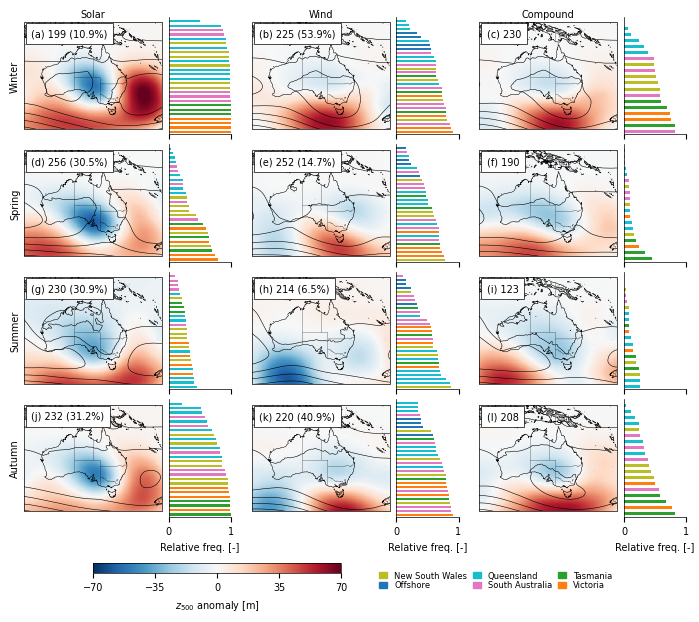

In [58]:
plot_synoptics(
    daily_plot_z500_mslp,
    r'$z_{500}$ anomaly [m]',
    np.arange(-70, 71, 35),
    'neither',
    save_fig=True
)

In [43]:
# Plotting data - Wind speed/direction (u and v)
daily_plot_u_v = get_plot_data(
    daily_simul_dict,
    daily_u100,
    daily_v100,
    'u',
    'v',
    thresh_spatial
)

In [44]:
# Plotting data - tcc anoms and T anoms
daily_plot_tcc_t2m_anoms = get_plot_data(
    daily_simul_dict,
    daily_tcc_anoms,
    daily_2t_anoms,
    'tcc_anoms',
    '2t_anoms',
    thresh_spatial
)

In [45]:
daily_plot_tcc_t2m_anoms['Winter']['Solar']['tcc_anoms'].max()

<xarray.DataArray 'tcc' ()>
array(0.55217481)
Coordinates:
    quantile  float64 0.25

In [59]:
def plot_wind_tcc_t(ax1, ax2, tcc_da, u_da, v_da, t_da, region_dict, text=None, tcc_anoms=False):
    """
    Plot total cloud cover shading, wind direction/speed arrows and
    temperature anomalies as contours on an axis.
    TCC can be either full field or anomalies.
    
    Bar plot of regions' tendency to be part of spatially
    extensive days.
    """
    ### =========== Diagnostics subplot     
    if tcc_anoms:
        # m = 1
        # tcc_levels = np.arange(-m, m+1, 0.1)
        # tcc_levels = [i for i in mslp_levels if i != 0]
        tcc_vmin = -0.3
        tcc_vmax = 0.3
    else:
        # mslp_levels = np.arange(0, 1, 0.1)
        tcc_vmin = 0
        tcc_vmax = 1
    
    ax1.add_feature(
        cartopy.feature.NaturalEarthFeature(
            category='cultural',
            name='admin_1_states_provinces',
            scale='10m'
        ),
        facecolor='none',
        edgecolor='k',
        lw=.1,
        rasterized=True
    )
    ax1.coastlines(lw=.3, rasterized=True)
    ax1.set_extent([105, 170, 0, -50], crs=ccrs.PlateCarree())
    
    # ===== TCC shading
    p = tcc_da.plot(
        ax=ax1,
        transform=ccrs.PlateCarree(),
        vmin=tcc_vmin,
        vmax=tcc_vmax,
        cmap='PuOr',
        add_colorbar=False,
        rasterized=True
    )
    
    # ====== Wind Quiver plot
    step = 20
    p_w = ax1.quiver(
        u_da.lon.values[::step],
        u_da.lat.values[::step],
        u_da.values[::step,::step],
        v_da.values[::step,::step],
        angles='xy',
        scale=2,
        scale_units='xy',
        width=0.005,
        # headwidth=8,
        transform=ccrs.PlateCarree(),
        # rasterized=True
    )
    
    # ====== Temperature anomaly contours
    m = 20
    levels = np.arange(-m, m+1, 1)
    levels = [i for i in levels if i != 0]
    p_t = t_da.plot.contour(
        ax=ax1,
        levels=levels,
        colors=colors[3],
        transform=ccrs.PlateCarree(),
        linewidths=.5
    )
    try:
        ax1.clabel(p_t, np.array([-1, 1]), fmt='%d', color=colors[3])
    except:
        pass
    
    ax1.set_title('', fontsize=plt_params['font.size'] / 1.7, pad=0)
    
    if isinstance(text, str):
        ax1.text(0.055, 0.94, text, ha='left', va='top',
                 bbox=dict(facecolor='white', alpha=1, lw=0.5),
                 transform=ax1.transAxes)
    
    # ============ Region frequency barplot
    if region_dict is not None:
        x = region_dict['data'].values
        y = region_dict['data'].region.values
        ax2.barh(y, x, color=region_dict['colors'], height=.5)

        ax2.set_xlim(0, 1)
        ax2.set_xticks([0,1.])
        ax2.set_xticklabels('')

        ax2.set_ylim(-0.5, len(y))
        ax2.set_yticks([])

        for pos in ['top', 'right']:
            ax2.spines[pos].set_visible(False)
    
    return p, p_w

/g/data/w42/dr6273/apps/conda/envs/pangeo/lib/python3.10/site-packages/cartopy/mpl/geoaxes.py:1614: UserWarning: No contour levels were found within the data range.
  result = super().contour(*args, **kwargs)
/g/data/w42/dr6273/apps/conda/envs/pangeo/lib/python3.10/site-packages/cartopy/mpl/geoaxes.py:1614: UserWarning: No contour levels were found within the data range.
  result = super().contour(*args, **kwargs)


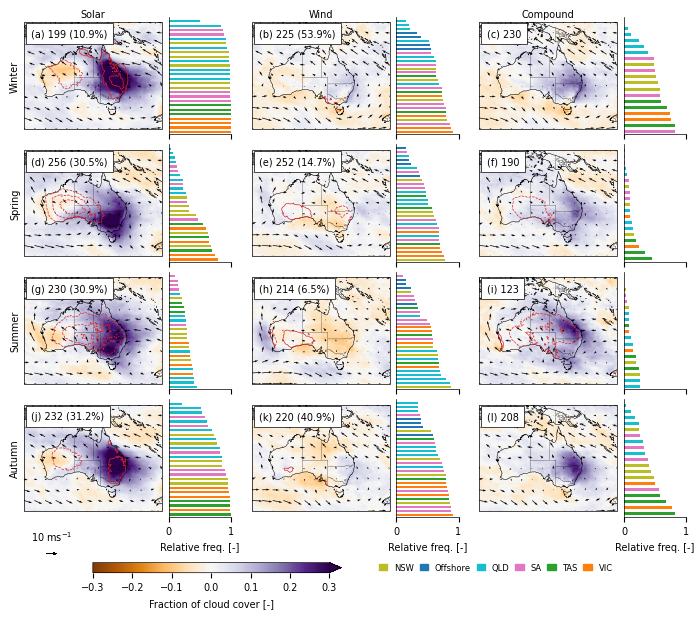

In [59]:
plot_synoptics(
    daily_plot_tcc_t2m_anoms,
    'Fraction of cloud cover anomaly [-]',
    np.arange(-0.3, 0.31, 0.1),
    'max',
    daily_plot_u_v,
    anoms=True,
    save_fig=False
)

In [116]:
def plot_synoptics_no_bar(plot_dict, cbar_label, cbar_ticks, cbar_extend, uv_plot_dict=None, anoms=False, save_fig=False):
    """
    Plot synoptic maps.
    
    plot_dict: dictionary containing data for plotting on map
    uv_plot_dict: disctionary containing u and v data for quiver plot
    cbar_label: colorbar label for da1
    cbar_ticks: ticks for colorbar
    cbar_extend: extend mode for colorbar
    anoms: Bool. Whether second variable is anomalies or not.
    save_fig: Bool. Whether to save figure or not.
    """
    with plt.rc_context(plt_params):
        fig, axes = plt.subplots(4, 3, figsize=(5., 5.2), subplot_kw={"projection": ccrs.PlateCarree()}) 

        n_event_text = get_frequency_text(daily_simul_dict, thresh_spatial)
        
        da1_name = list(plot_dict['Winter']['Solar'].keys())[0]
        da2_name = list(plot_dict['Winter']['Solar'].keys())[1]

        count = 0
        for i, season in enumerate(list(season_dict.keys())[1:]):
            for j, (name, var) in enumerate(zip(daily_simul_dict.keys(), daily_simul_dict.values())):
                # Get map data
                p1 = plot_dict[season][name][da1_name]
                p2 = plot_dict[season][name][da2_name]
                
                ax1 = axes[i,j]
                ax2 = None

                # Plot
                if uv_plot_dict is None:
                    p = plot_z_mslp(ax1, ax2, p1, p2, None,
                                    text='(' + letters[count] + ') ' + n_event_text[i, j], mslp_anoms=anoms)
                else:
                    u = uv_plot_dict[season][name]['u']
                    v = uv_plot_dict[season][name]['v']
                    p, p_w = plot_wind_tcc_t(ax1, ax2, p1, u, v, p2, None,
                                             text='(' + letters[count] + ') ' + n_event_text[i, j], tcc_anoms=anoms)
                    
                count += 1

        plt.subplots_adjust(hspace=0., wspace=0.0)

        # Labels and titles
        axes[0,0].set_title("Solar")
        axes[0,1].set_title("Wind")
        axes[0,2].set_title("Compound")
        # axes[0,0].text(0.5, 1.05, 'Solar', ha='center', transform=axes[0][0].transAxes)
        # axes[1,0].text(0.5, 1.05, 'Wind', ha='center', transform=axes[1][0].transAxes)
        # axes[2,0].text(0.5, 1.05, 'Compound', ha='center', transform=axes[2][0].transAxes)

        axes[0,0].text(-0.1, 0.5, 'Winter', rotation=90, va='center', transform=axes[0,0].transAxes)
        axes[1,0].text(-0.1, 0.5, 'Spring', rotation=90, va='center', transform=axes[1,0].transAxes)
        axes[2,0].text(-0.1, 0.5, 'Summer', rotation=90, va='center', transform=axes[2,0].transAxes)
        axes[3,0].text(-0.1, 0.5, 'Autumn', rotation=90, va='center', transform=axes[3,0].transAxes)

        # Colorbar
        cb_ax1 = fig.add_axes([0.27, 0.07, 0.5, 0.02])
        cb1 = fig.colorbar(p, cax=cb_ax1, orientation='horizontal', ticks=cbar_ticks, extend=cbar_extend)
        cb1.ax.set_xlabel(cbar_label)
            
        # Quiver legend
        if uv_plot_dict is None:
            pass
        else:
            qk = axes[3,0].quiverkey(p_w, -1.9, -0.38, 10, label=r'10 ms$^{-1}$', labelpos='N', labelcolor='k')
            
        plt.subplots_adjust(hspace=0.07, wspace=0.05)
            
        if save_fig:
            plt.savefig('./figures/Fig2_synoptics.pdf', format='pdf', dpi=400, bbox_inches='tight')

/g/data/w42/dr6273/apps/conda/envs/pangeo/lib/python3.10/site-packages/cartopy/mpl/geoaxes.py:1614: UserWarning: No contour levels were found within the data range.
  result = super().contour(*args, **kwargs)
/g/data/w42/dr6273/apps/conda/envs/pangeo/lib/python3.10/site-packages/cartopy/mpl/geoaxes.py:1614: UserWarning: No contour levels were found within the data range.
  result = super().contour(*args, **kwargs)


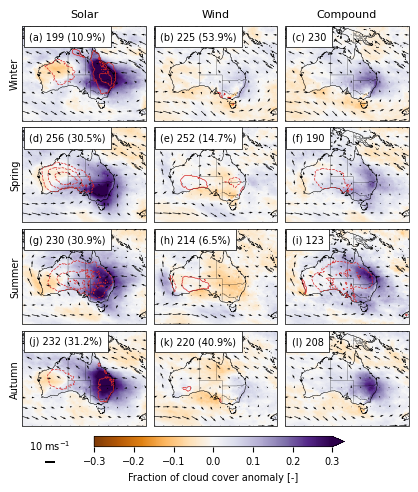

In [117]:
plot_synoptics_no_bar(
    daily_plot_tcc_t2m_anoms,
    'Fraction of cloud cover anomaly [-]',
    np.arange(-0.3, 0.31, 0.1),
    'max',
    daily_plot_u_v,
    anoms=True,
    save_fig=True
)

### PDFs of city temperatures during normal versus drought days

In [50]:
# def hist_t_plot(ax, season, city):
#     """
#     Plot histograms of temperature for a season,
#     and on solar, wind or compound days (also in that season).
#     """
#     if season == 'Winter':
#         tmin = -5
#         tmax = 25
#     elif (season == 'Spring') | (season == 'Autumn'):
#         tmin = 0
#         tmax = 30
#     else:
#         tmin = 5
#         tmax = 35
    
#     fill_alpha = 0.3

#     months = season_dict[season]
#     b = np.linspace(tmin, tmax, len(range(tmin, tmax)) + 1)
#     bins, hist = fn.hist_data(fn.month_subset(gcc_t.sel(region=city), months), b)
#     p_clim = ax.plot(bins, hist, color='k', lw=0.8, alpha=0.8, zorder=0, label='All')
#     # ax.fill_between(bins, 0, hist, color='k', alpha=fill_alpha - 0.1)

#     for var_name, var, color in zip(
#         ['Solar', 'Wind', 'Compound'],
#         [simul_mssrd, simul_100w, simul_100w_mssrd],
#         [colors[1], colors[0], colors[4]]
#         # [simul_100w_mssrd],
#         # [colors[4]]
#     ):
#         _, _, _, d = fn.subset_on_events(var, gcc_t.sel(region=city), season, thresh_spatial)

#         bins, hist = fn.hist_data(d, b)
#         # ax.plot(bins, hist, color=color, lw=0.8, alpha=1)
#         ax.fill_between(bins, 0, hist, color=color, alpha=fill_alpha, zorder=1, label=var_name)
        
#         ax.axvline(16, ls='--', lw=0.5, color=colors[0])
#         ax.axvline(21, ls='--', lw=0.5, color=colors[3])
        
#         ax.set_ylim(-0.015, 0.3)
#         ax.set_yticks([0, 0.15, 0.3])
        
#         ax.set_xticks(np.arange(tmin, tmax+1, 10))
        
#         ax.legend()

In [51]:
# city_names = {
#     'SYD': 'Sydney',
#     'MLB': 'Melbourne',
#     'BNE': 'Brisbane',
#     'ADL': 'Adelaide',
#     'HBA': 'Hobart',
#     'ACT': 'Canberra'
# }

In [52]:
# with plt.rc_context(plt_params):
    
#     fig, axes = plt.subplots(6, 4, figsize=(6.9, 5.5))
    
#     for j, season in enumerate(list(season_dict.keys())[1:]):
#         for i, city in enumerate(gcc_t['region'].values):
        
#             hist_t_plot(axes[i,j], season, city)
            
#             if i == 0:
#                 axes[i,j].set_title(season)
                
#             if i < 5:
#                 axes[i,j].set_xticklabels('')
#             else:
#                 axes[i,j].set_xlabel(r'Temperature [$^{\circ}$C]')
#             if j > 0:
#                 axes[i,j].set_yticklabels('')
#             else:
#                 axes[i,j].set_ylabel(city_names[city] + '\n'+r'Density [$^{\circ}$C$^{-1}$]')
                
#             if (i == 0) & (j == 0):
#                 axes[i,j].legend(loc=(0., 0.2), frameon=False)
#             else:
#                 axes[i,j].legend().set_visible(False)
                
#     plt.subplots_adjust(hspace=0.25, wspace=0.08)
    
#     plt.savefig('./figures/FigY_temperature_pdfs.pdf', format='pdf', dpi=400, bbox_inches='tight')

# Close cluster

In [118]:
client.close()
cluster.close()